Dota 2 — многопользовательская компьютерная игра жанра MOBA. Игроки играют между собой матчи. В каждом матче, как правило, участвует 10 человек. Матчи формируются из живой очереди, с учётом уровня игры всех игроков. Перед началом игры игроки автоматически разделяются на две команды по пять человек. Одна команда играет за светлую сторону (The Radiant), другая — за тёмную (The Dire). Цель каждой команды — уничтожить главное здание базы противника, трон.

Вам нужно построить модель, которая по данным о первых пяти минутах матча будет предсказывать его исход — то есть определять команду-победителя.

Чтобы выполнить это задание, вам необходимо провести ряд исследований, сравнить несколько алгоритмов машинного обучения и проверить эффект от ряда манипуляций с признаками. Также, если вам понравится работать с этими данными, вы можете принять участие в соревновании на Kaggle и сравнить свои навыки с другими участниками курса!

In [161]:
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

### Подход 1: градиентный бустинг "в лоб"

**1.** Считайте таблицу с признаками из файла features.csv с помощью кода, приведенного выше. Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).

In [40]:
train = pd.read_csv(r'C:\Users\snkna\Downloads\features.csv', index_col="match_id")
# Тк radiant_win целевая переменная удалим ее позже
game_result_columns_list = ['duration','tower_status_radiant','tower_status_dire','barracks_status_radiant','barracks_status_dire']
X_train = train.drop(game_result_columns_list,axis=1)
X_train.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,radiant_win
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0,1
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0,0
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0,0
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0,0


**2.** Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

In [41]:
nan_columns_list = list(X_train.count()[X_train.count()<X_train.shape[0]].index)
# % Заполенных занчений в столбцах с пропусками
round(X_train.count()[X_train.count()<X_train.shape[0]]/X_train.shape[0]*100,1)

first_blood_time               79.9
first_blood_team               79.9
first_blood_player1            79.9
first_blood_player2            54.8
radiant_bottle_time            83.9
radiant_courier_time           99.3
radiant_flying_courier_time    71.7
radiant_first_ward_time        98.1
dire_bottle_time               83.4
dire_courier_time              99.3
dire_flying_courier_time       73.2
dire_first_ward_time           98.1
dtype: float64

In [42]:
# % Пропусков
l1 = []
for i in nan_columns_list:
    l1.append((i,round(X_train[X_train[i].isna()==True].shape[0]/X_train.shape[0]*100,2)))
nan_frame = pd.DataFrame(data=l1,columns=['nan_col','%_nan_all'])
nan_frame

,nan_col,%_nan_all
0,first_blood_time,20.11
1,first_blood_team,20.11
2,first_blood_player1,20.11
3,first_blood_player2,45.24
4,radiant_bottle_time,16.14
5,radiant_courier_time,0.71
6,radiant_flying_courier_time,28.26
7,radiant_first_ward_time,1.89
8,dire_bottle_time,16.60
9,dire_courier_time,0.70


Все эти признаки принимают 0-е значение, тк это признаки события "первая кровь" (first blood). **Если событие "первая кровь" не успело произойти за первые 5 минут, то признаки принимают пропущенное значение**:

- **first_blood_time(игровое время первой крови)** в **20%** случаев первой крови **нет в первые 5 минут игры.**
- **first_blood_team(команда, совершившая первую кровь (0 — Radiant, 1 — Dire))** в *20%* случаев первой крови **нет в первые 5 минут игры.**
- **first_blood_player1(игрок, причастный к событию)** в **20%** случаев **первой крови нет в первые 5 минут игры.**
- **first_blood_player2(второй игрок, причастный к событию)** в **45%** случаев **убийство первой крови совершается 1-м игроком.**

Признаки для каждой команды (префиксы radiant_ и dire_)
- **bottle_time(время первого приобретения командой предмета "bottle")** в **16%** случаев (для radian и dire)  случаев команда **не приобретает предмет "bottle" в первые 5 минут игры.**
- **courier_time(время приобретения предмета "courier" )** в **0.7%** случаев (для radian и dire) случаев команда **не покупает предмет "courier" в первые 5 минут игры.**
- **flying_courier_time(время приобретения предмета "flying_courier" )** в **28% для dire** и в **27% для radiant** случаев команда **не покупает предмет "flying_courier" в первые 5 минут игры.**
- first_ward_time(время установки командой первого "наблюдателя", т.е. предмета, который позволяет видеть часть игрового поля) в **1.9%** случаев команда **не усланавливает первого "наблюдателя" в первые 5 минут игры.**

**3.** Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.

In [43]:
X_train = X_train.fillna(0)

**4.** Какой столбец содержит целевую переменную? Запишите его название.
Это столбец **radiant_win**

In [44]:
# 1, если победила команда Radiant, 0 — иначе
y = X_train['radiant_win']
X_train.drop("radiant_win", axis=1,inplace=True)

**5.** Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

n_estimators: 10
learning_rate:'0.1,roc_auc_5kfold_score_mean: 0.665,Time elapsed: 0:00:35.070167
learning_rate:'0.3,roc_auc_5kfold_score_mean: 0.684,Time elapsed: 0:00:36.465437
learning_rate:'0.5,roc_auc_5kfold_score_mean: 0.686,Time elapsed: 0:00:35.808193
learning_rate:'0.7,roc_auc_5kfold_score_mean: 0.686,Time elapsed: 0:00:35.246699
learning_rate:'0.9,roc_auc_5kfold_score_mean: 0.684,Time elapsed: 0:00:37.134646
n_estimators: 20
learning_rate:'0.1,roc_auc_5kfold_score_mean: 0.682,Time elapsed: 0:01:11.830816
learning_rate:'0.3,roc_auc_5kfold_score_mean: 0.696,Time elapsed: 0:01:11.562534
learning_rate:'0.5,roc_auc_5kfold_score_mean: 0.698,Time elapsed: 0:01:11.263378
learning_rate:'0.7,roc_auc_5kfold_score_mean: 0.697,Time elapsed: 0:01:11.658280
learning_rate:'0.9,roc_auc_5kfold_score_mean: 0.694,Time elapsed: 0:01:11.877690
n_estimators: 30
learning_rate:'0.1,roc_auc_5kfold_score_mean: 0.690,Time elapsed: 0:01:47.207290
learning_rate:'0.3,roc_auc_5kfold_score_mean: 0.702,Time e

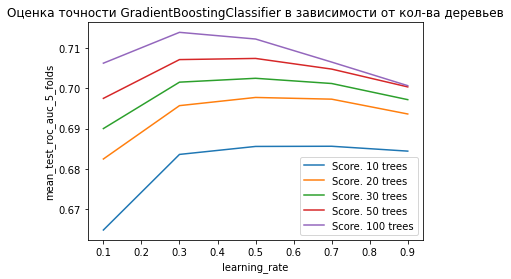

In [235]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
n_estimators_list = [10, 20, 30,50,100]
learning_rate_list = np.arange(0.1, 1, 0.2)
scores_list = []
df = {}

for j in n_estimators_list:
    print('\033[1mn_estimators:\033[0m',j)
    score_list = []
    for w in learning_rate_list:
        clf = GradientBoostingClassifier(random_state=42,n_estimators=j,learning_rate=w)
        start_time = datetime.datetime.now()   
        scores = cross_val_score(clf, X_train, y, cv=cv, scoring='roc_auc').mean()
        end_time = datetime.datetime.now()
        print(f"\033[95mlearning_rate:\033[0m'{round(w,1)},roc_auc_5kfold_score_mean: {scores:.3f},Time elapsed: {end_time - start_time}")
#         print("Time elapsed:",end_time - start_time)
        score_list.append(scores)
    df[j] = score_list
    
plt.figure()
for m in n_estimators_list:
    plt.plot(np.arange(0.1, 1, 0.2),df[m])
plt.legend(['Score. 10 trees','Score. 20 trees','Score. 30 trees','Score. 50 trees','Score. 100 trees'], loc = 'best')
plt.xlabel('learning_rate')
plt.ylabel('mean_test_roc_auc_5_folds')
plt.title('Оценка точности GradientBoostingClassifier в зависимости от кол-ва деревьев')
plt.show()

6. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Инструкцию по измерению времени можно найти выше по тексту. Какое качество при этом получилось?

In [164]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
clf = GradientBoostingClassifier(random_state=42,n_estimators=30,learning_rate=0.5)
clf.fit(X_train, y)
start_time = datetime.datetime.now()
cv_est = cross_val_score(clf, X_train, y, cv=cv, scoring='roc_auc').mean()
time_est = datetime.datetime.now() - start_time
print('Кросс-валидация для градиентного бустинга с 30 деревьями заняла {}.\n Показатель метрики качества AUC-ROC в таком случае равен {}.'.format(time_est,cv_est))

Кросс-валидация для градиентного бустинга с 30 деревьями заняла 0:01:57.775709./n Показатель метрики качества AUC-ROC в таком случае равен 0.7024742811365648.


In [223]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
clf = GradientBoostingClassifier(random_state=42,n_estimators=100,learning_rate=0.3)
clf.fit(X_train, y)
start_time = datetime.datetime.now()
cv_est = cross_val_score(clf, X_train, y, cv=cv, scoring='roc_auc').mean()
time_est = datetime.datetime.now() - start_time
print('Кросс-валидация для градиентного бустинга с 100 деревьями заняла {}.\n Показатель метрики качества AUC-ROC в таком случае равен {}.'.format(time_est,cv_est))

Кросс-валидация для градиентного бустинга с 100 деревьями заняла 0:06:35.203366.
 Показатель метрики качества AUC-ROC в таком случае равен 0.713874396407482.


7. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что можно сделать, чтобы ускорить его обучение при увеличении количества деревьев?

**Ответ**: Увеличение количества деревьев также показатель метрики AUC-ROC, приближая его к 0.72. Однако для 100 деревьев время обучения 6.5 мин при AUC-ROC=0.71. Для достижения большего качества имеет смысл использовать более 30 деревьев. Для ускорения обучения можно использовать не всю выборку, а некоторое ее подмножество — например, половину объектов. Также можно уменьшить глубину деревьев (max_depth).

### Подход 2: логистическая регрессия

**1.** Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

Наилучшее значение показателя AUC-ROC достигается при C = 0.01 и равно 0.72.


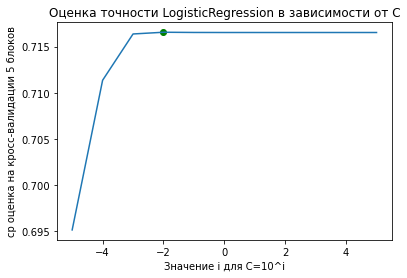

,C_value,roc_auc_5kfold_score_mean,time_elapsed
0,0.00001,0.695155,00:00:02.347249
1,0.00010,0.711352,00:00:02.823753
2,0.00100,0.716363,00:00:04.237803
3,0.01000,0.716550,00:00:06.075695
4,0.10000,0.716527,00:00:06.243046
5,1.00000,0.716522,00:00:05.927999
6,10.00000,0.716522,00:00:06.565957
7,100.00000,0.716522,00:00:05.945598
8,1000.00000,0.716522,00:00:06.018788
9,10000.00000,0.716522,00:00:06.263735


In [249]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)


def LR_define(X,y):
    scores_lr_list = []
    result_df = pd.DataFrame()
    C_array =  np.power(10.0, np.arange(-5, 6))
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    for n,k in enumerate(C_array):
        result_df.loc[n,'C_value'] = k
        lr_model = LogisticRegression(C=k,random_state=42,max_iter=1200)
        start_time = datetime.datetime.now()
        cv_est = cross_val_score(lr_model, X, y, cv=cv, scoring='roc_auc').mean()
        end_time = datetime.datetime.now()
        result_df.loc[n,'roc_auc_5kfold_score_mean'] = round(cv_est,6)
        result_df.loc[n,'time_elapsed'] = end_time - start_time
        scores_lr_list.append(cv_est)
        
    #Самым оптимальным будет первый C с максимальной оценкой качетва. Этому будет соответствовать алгоритм с меньшим временем обучения.
    best_C = C_array[np.argmax(scores_lr_list)]
    print(f"Наилучшее значение показателя AUC-ROC достигается при C = {best_C:.2f} и равно {np.max(scores_lr_list):.2f}.")
    
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(np.arange(-5, 6),scores_lr_list)
    ax.scatter(np.arange(-5, 6)[np.argmax(scores_lr_list)],np.max(scores_lr_list),c='green')
    ax.set_xlabel('Значение i для С=10^i')
    ax.set_ylabel('ср оценка на кросс-валидации 5 блоков')
    plt.title('Оценка точности LogisticRegression в зависимости от С')
    plt.show()
    return result_df

result_df = LR_define(X_train_scaled,y)
result_df

**Вывод:** Наилучшее значение показателя AUC-ROC достигается при C = 0.01 и равно 0.72.
Это сравнимо с градиентным бустингом по 200 - 250 деревьям, при этом логистическая регрессия работает заметно быстрее. Отсутствие разницы с градиентным бустингом может говорить о том, что характер связи между данными фичами и целевой переменной - линейный. Тогда такая связь хорошо описывается логистической регрессией и более сложные модели не нужны.

**2.** Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем можно объяснить это изменение?

Наилучшее значение показателя AUC-ROC достигается при C = 0.01 и равно 0.72.


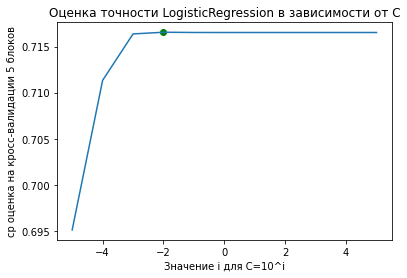

,C_value,roc_auc_5kfold_score_mean,time_elapsed,num_roc_auc_5kfold_score_mean,num_time_elapsed
0,0.00001,0.695155,00:00:02.347249,0.695092,00:00:02.303650
1,0.00010,0.711352,00:00:02.823753,0.711333,00:00:02.688037
2,0.00100,0.716363,00:00:04.237803,0.716376,00:00:04.155649
3,0.01000,0.716550,00:00:06.075695,0.716559,00:00:05.688547
4,0.10000,0.716527,00:00:06.243046,0.716534,00:00:05.517308
5,1.00000,0.716522,00:00:05.927999,0.716530,00:00:05.892946
6,10.00000,0.716522,00:00:06.565957,0.716531,00:00:05.704103
7,100.00000,0.716522,00:00:05.945598,0.716530,00:00:05.479383
8,1000.00000,0.716522,00:00:06.018788,0.716530,00:00:05.688689
9,10000.00000,0.716522,00:00:06.263735,0.716530,00:00:05.467496


In [250]:
cat_columns = ['lobby_type','r1_hero','r2_hero','r3_hero','r4_hero','r5_hero','d1_hero','d2_hero','d3_hero','d4_hero','d5_hero']
X_train_scaled_num = X_train_scaled.drop(cat_columns,axis=1)

result_df_num = LR_define(X_train_scaled_num,y)
result_df_num.rename(columns={'roc_auc_5kfold_score_mean':'num_roc_auc_5kfold_score_mean',
                      'time_elapsed':'num_time_elapsed'},inplace=True)
result_df = result_df.merge(result_df_num,how='left',on='C_value')
result_df

**Вывод:** удаление категориальных признаков на десятитысячные доли улучшило качество предсказания. Получается, что в предыдущей модели эти признаки никак не влияли на результат предсказания, модель не посчитала их информативными и практически не использовала для прогноза. Отличия есть на уровне сотых и тысячных долей секунд времени выполнения

**3.** На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).

In [251]:
hero_columns = ['r1_hero','r2_hero','r3_hero','r4_hero','r5_hero','d1_hero','d2_hero','d3_hero','d4_hero','d5_hero']
unique_heroes = np.unique(X_train[hero_columns].values.ravel())
N = max(unique_heroes)
print(f"Число уникальных героев в train: {len(unique_heroes)}. Максимальный ID героя: {N}.")

Число уникальных героев в train: 108. Максимальный ID героя: 112.


**4.** Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данной преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.

In [252]:
# N — количество различных героев в выборке
X_pick = np.zeros((X_train.shape[0], N))
print(X_pick.shape)
for i, match_id in enumerate(X_train.index):
    for p in range(1,6):
        X_pick[i, X_train.loc[match_id, f"r{p}_hero"]-1] = 1
        X_pick[i, X_train.loc[match_id, f"d{p}_hero"]-1] = -1
X_heroes_dummy = pd.DataFrame(X_pick, index=X_train.index, columns=[f"hero_{i}" for i in range(N)])
X_heroes_dummy_num =  X_train_scaled_num.merge(X_heroes_dummy,how='left',left_index = True,right_index=True)

(97230, 112)


5. Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

Наилучшее значение показателя AUC-ROC достигается при C = 0.10 и равно 0.75.


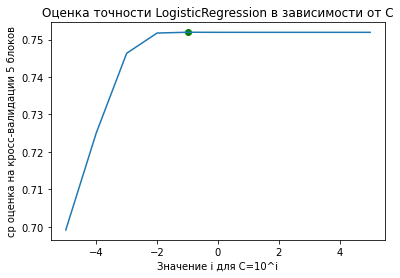

In [253]:
result_df_num_heroes_dummy = LR_define(X_heroes_dummy_num,y)

**Вывод:** После добавления "мешка слов" по героям качество заметно улучшилось. Это объясняется тем, что вместо отсутствия данных о героях или случайного шума из id мы имеем осмысленную разреженную матрицу для построения предсказания.

6. Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

Лучшей из исследованных моделей оказалась логистическая регрессия c обнуленными значениями пропусков, с использованием "мешка слов" для кодирования признаков принадлежности типов героев к командам, с l2-регуляризацией с параметром C = 10^-2 построенная на стандартизированных данных. Используем эту модель для предсказания итога игры на тестовых данных.

In [256]:
X_test = pd.read_csv(r'C:\Users\snkna\Downloads\\features_test.csv', index_col='match_id')
X_test = X_test.fillna(0)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)



hero_columns = ['r1_hero','r2_hero','r3_hero','r4_hero','r5_hero','d1_hero','d2_hero','d3_hero','d4_hero','d5_hero']
unique_heroes = np.unique(X_test[hero_columns].values.ravel())
N = max(unique_heroes)
# N — количество различных героев в выборке
X_pick = np.zeros((X_test_scaled.shape[0], N))

for i, match_id in enumerate(X_test_scaled.index):
    for p in range(1,6):
        X_pick[i, X_test.loc[match_id, f"r{p}_hero"]-1] = 1
        X_pick[i, X_test.loc[match_id, f"d{p}_hero"]-1] = -1
        
cat_columns = ['lobby_type','r1_hero','r2_hero','r3_hero','r4_hero','r5_hero','d1_hero','d2_hero','d3_hero','d4_hero','d5_hero']
X_test_scaled_num = X_test_scaled.drop(cat_columns,axis=1)
X_heroes_dummy_test = pd.DataFrame(X_pick, index=X_test.index, columns=[f"hero_{i}" for i in range(N)])
X_heroes_dummy_num_test =  X_test_scaled_num.merge(X_heroes_dummy_test,how='left',left_index = True,right_index=True)



learner = LogisticRegression(C = 10**-1,random_state=42,max_iter=1200)
learner.fit(X_heroes_dummy_num,y)
pred = learner.predict_proba(X_heroes_dummy_num_test)[:,1]


Убедимся в том, что предсказания адекватные: лежат в промежутке [0, 1], а также не повторяют (ну или почти никогда не повторяются). Рассчитаем минимальное, максимальное значения прогнозов, подсчитаем количество прогнозов и количество уникальных прогнозов для тестовых данных.

In [270]:
pd.Series(pred).describe()

count    17177.000000
mean         0.517030
std          0.220950
min          0.008426
25%          0.346117
50%          0.522167
75%          0.691643
max          0.996372
dtype: float64

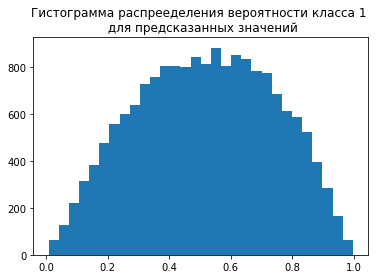

In [271]:
plt.hist(pred,bins=30)
plt.title('Гистограмма распрееделения вероятности класса 1 \n для предсказанных значений');


Предсказания адекватные